# VDEH Datenanreicherung - Report Generator

**Zweck:** Generiert einen umfassenden Projektbericht als Markdown-Datei

## Output
- `reports/vdeh_enrichment_report.md` - Vollständiger Projektbericht
- `reports/figures/` - Visualisierungen

## Inhalt des Reports
1. Zusammenfassung
2. Daten-Pipeline Übersicht
3. DNB Enrichment Ergebnisse
4. Fusion Ergebnisse
5. Datenqualität Analyse
6. Technische Details

In [1]:
# Setup und Imports
import sys
from pathlib import Path
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Project setup
project_root = Path.cwd()
while not (project_root / 'config.yaml').exists() and project_root.parent != project_root:
    project_root = project_root.parent
sys.path.insert(0, str(project_root / 'src'))

from utils.notebook_utils import setup_notebook
project_root, config = setup_notebook()

# Paths
processed_dir = config.project_root / config.get('paths.data.vdeh.processed')
reports_dir = config.project_root / 'reports'
figures_dir = reports_dir / 'figures'

# Create directories
reports_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

print(f"Project: {config.get('project.name')}")
print(f"Reports: {reports_dir}")

2025-12-11 19:22:48 - utils.notebook_utils - INFO - Searching for project root...


2025-12-11 19:22:48 - utils.notebook_utils - INFO - Project root found: /media/sz/Data/Bibo/analysis


2025-12-11 19:22:48 - utils.notebook_utils - INFO - Loading configuration...


2025-12-11 19:22:48 - config_loader - INFO - Configuration loaded from /media/sz/Data/Bibo/analysis/config.yaml


2025-12-11 19:22:48 - utils.notebook_utils - INFO - Configuration loaded successfully: Dual-Source Bibliothek Bestandsvergleich


Project: Dual-Source Bibliothek Bestandsvergleich
Reports: /media/sz/Data/Bibo/analysis/reports


In [2]:
# Daten laden
print("Lade Daten...")

# Fused data (Endergebnis)
fused_path = processed_dir / '05_fused_data.parquet'
df_fused = pd.read_parquet(fused_path) if fused_path.exists() else None

# DNB Raw data
dnb_raw_path = processed_dir / 'dnb_raw_data.parquet'
df_dnb_raw = pd.read_parquet(dnb_raw_path) if dnb_raw_path.exists() else None

# DNB Title/Author data
dnb_ta_path = processed_dir / 'dnb_title_author_data.parquet'
df_dnb_ta = pd.read_parquet(dnb_ta_path) if dnb_ta_path.exists() else None

# Enriched data (vor Fusion)
enriched_path = processed_dir / '04_dnb_enriched_data.parquet'
df_enriched = pd.read_parquet(enriched_path) if enriched_path.exists() else None

# Original data (MARC21 raw - Stage 01 als Baseline!)
original_path = processed_dir / '01_loaded_data.parquet'
df_original = pd.read_parquet(original_path) if original_path.exists() else None

# Metadata
fusion_metadata_path = processed_dir / '05_metadata.json'
fusion_metadata = json.load(open(fusion_metadata_path)) if fusion_metadata_path.exists() else {}

print(f"Fused data: {len(df_fused):,} records" if df_fused is not None else "Fused data: nicht gefunden")
print(f"DNB Raw: {len(df_dnb_raw):,} records" if df_dnb_raw is not None else "DNB Raw: nicht gefunden")
print(f"DNB T/A: {len(df_dnb_ta):,} records" if df_dnb_ta is not None else "DNB T/A: nicht gefunden")

Lade Daten...


Fused data: 58,305 records
DNB Raw: 10,665 records
DNB T/A: 17,488 records


In [3]:
# Statistiken berechnen
print("Berechne Statistiken...")

stats = {}

# Basis-Statistiken
if df_fused is not None:
    stats['total_records'] = len(df_fused)
    
    # Vollständigkeit VORHER (Original MARC21)
    if df_original is not None:
        stats['original_gaps'] = {
            'title_missing': (df_original['title'].isna()).sum(),
            'isbn_missing': (df_original['isbn'].isna()).sum(),
            'issn_missing': (df_original['issn'].isna()).sum() if 'issn' in df_original.columns else 0,
            'authors_missing': (df_original['authors_str'].isna() | (df_original['authors_str'] == '')).sum(),
            'year_missing': df_original['year'].isna().sum(),
            'publisher_missing': df_original['publisher'].isna().sum(),
            'language_missing': 0  # Wird gleich berechnet
        }
        
        # Language gaps in original
        if 'language' in df_original.columns:
            stats['original_gaps']['language_missing'] = df_original['language'].isna().sum()
        else:
            stats['original_gaps']['language_missing'] = len(df_original)
    
    # Vollständigkeit NACHHER (nach Pipeline)
    stats['completeness'] = {
        'title': df_fused['title'].notna().sum(),
        'authors': (df_fused['authors_str'].notna() & (df_fused['authors_str'] != '')).sum(),
        'year': df_fused['year'].notna().sum(),
        'publisher': df_fused['publisher'].notna().sum(),
        'isbn': df_fused['isbn'].notna().sum() if 'isbn' in df_fused.columns else 0,
        'issn': df_fused['issn'].notna().sum() if 'issn' in df_fused.columns else 0
    }
    
    # NEWLY FILLED: Records that had NO value in original but HAVE value now
    if df_original is not None:
        # ISBN
        had_no_isbn_01 = df_original['isbn'].isna() if 'isbn' in df_fused.columns else pd.Series([True] * len(df_fused))
        has_isbn_05 = df_fused['isbn'].notna() if 'isbn' in df_fused.columns else pd.Series([False] * len(df_fused))
        
        # ISSN
        had_no_issn_01 = df_original['issn'].isna() if 'issn' in df_original.columns else pd.Series([True] * len(df_fused))
        has_issn_05 = df_fused['issn'].notna() if 'issn' in df_fused.columns else pd.Series([False] * len(df_fused))
        
        # Authors
        had_no_authors_01 = (df_original['authors_str'].isna() | (df_original['authors_str'] == ''))
        has_authors_05 = (df_fused['authors_str'].notna() & (df_fused['authors_str'] != ''))
        
        # Year
        had_no_year_01 = df_original['year'].isna()
        has_year_05 = df_fused['year'].notna()
        
        # Publisher
        had_no_pub_01 = df_original['publisher'].isna()
        has_pub_05 = df_fused['publisher'].notna()
        
        stats['gaps_filled'] = {
            'isbn': (had_no_isbn_01 & has_isbn_05).sum(),
            'issn': (had_no_issn_01 & has_issn_05).sum(),
            'authors': (had_no_authors_01 & has_authors_05).sum(),
            'year': (had_no_year_01 & has_year_05).sum(),
            'publisher': (had_no_pub_01 & has_pub_05).sum()
        }
    
    # Language-Statistiken (NEU)
    if 'language_final' in df_fused.columns:
        stats['language'] = {
            'marc21_count': (df_fused['language_source'] == 'marc21').sum() if 'language_source' in df_fused.columns else 0,
            'langdetect_count': (df_fused['language_source'] == 'langdetect').sum() if 'language_source' in df_fused.columns else 0,
            'total_with_lang': df_fused['language_final'].notna().sum(),
            'coverage_pct': df_fused['language_final'].notna().sum() / len(df_fused) * 100,
            'top_languages': df_fused['language_final'].value_counts().head(5).to_dict()
        }
        
        # Language gap filled
        original_with_lang = 0
        if df_original is not None and 'language' in df_original.columns:
            original_with_lang = df_original['language'].notna().sum()
        
        stats['language']['gap_filled'] = stats['language']['total_with_lang'] - original_with_lang
    
    # Fusion-Quellen
    if 'fusion_title_source' in df_fused.columns:
        stats['fusion_sources'] = df_fused['fusion_title_source'].value_counts().to_dict()
        stats['fusion_count'] = df_fused['fusion_title_source'].notna().sum()
        
        # Qualitätsmetriken
        stats['quality'] = {
            'validated': stats['fusion_sources'].get('confirmed', 0),
            'dnb_preferred': stats['fusion_sources'].get('dnb_id', 0) + stats['fusion_sources'].get('dnb_title_author', 0),
            'rejected_matches': stats['fusion_sources'].get('vdeh', 0),
            'total_processed': stats['fusion_count']
        }
    
    # DNB-Varianten
    if 'fusion_dnb_variant_selected' in df_fused.columns:
        stats['dnb_variants'] = df_fused['fusion_dnb_variant_selected'].value_counts().to_dict()

# DNB Enrichment Statistiken
if df_dnb_raw is not None:
    stats['dnb_isbn_issn'] = {
        'total': len(df_dnb_raw),
        'found': df_dnb_raw['dnb_found'].sum(),
        'not_found': (~df_dnb_raw['dnb_found']).sum(),
        'success_rate': df_dnb_raw['dnb_found'].mean() * 100
    }
    
    # ISBN/ISSN-Gewinn
    if 'dnb_isbn' in df_dnb_raw.columns:
        stats['isbn_gain'] = df_dnb_raw['dnb_isbn'].notna().sum()
    if 'dnb_issn' in df_dnb_raw.columns:
        stats['issn_gain'] = df_dnb_raw['dnb_issn'].notna().sum()

if df_dnb_ta is not None:
    stats['dnb_title_author'] = {
        'total': len(df_dnb_ta),
        'found': df_dnb_ta['dnb_found'].sum(),
        'not_found': (~df_dnb_ta['dnb_found']).sum(),
        'success_rate': df_dnb_ta['dnb_found'].mean() * 100
    }
    
    # ISBN/ISSN via Titel/Autor
    if 'dnb_isbn' in df_dnb_ta.columns:
        stats['isbn_gain_ta'] = df_dnb_ta['dnb_isbn'].notna().sum()
    if 'dnb_issn' in df_dnb_ta.columns:
        stats['issn_gain_ta'] = df_dnb_ta['dnb_issn'].notna().sum()

# Original-Daten Statistiken
if df_original is not None:
    stats['original_completeness'] = {
        'title': df_original['title'].notna().sum(),
        'authors': (df_original['authors_str'].notna() & (df_original['authors_str'] != '')).sum(),
        'year': df_original['year'].notna().sum(),
        'publisher': df_original['publisher'].notna().sum(),
        'isbn': df_original['isbn'].notna().sum() if 'isbn' in df_original.columns else 0
    }

# Detaillierte Verbesserungsanalyse (nur für fusionierte Records)
if df_fused is not None and df_original is not None and 'fusion_title_source' in df_fused.columns:
    # Records wo DNB-Daten übernommen wurden
    dnb_used_idx = df_fused[df_fused['fusion_title_source'].isin(['dnb_id', 'dnb_title_author'])].index
    
    stats['improvements'] = {}
    for field in ['title', 'authors_str', 'year', 'publisher']:
        if field == 'authors_str':
            orig_empty = (df_original.loc[dnb_used_idx, field].isna() | (df_original.loc[dnb_used_idx, field] == ''))
            now_filled = (df_fused.loc[dnb_used_idx, field].notna() & (df_fused.loc[dnb_used_idx, field] != ''))
        else:
            orig_empty = df_original.loc[dnb_used_idx, field].isna()
            now_filled = df_fused.loc[dnb_used_idx, field].notna()
        
        stats['improvements'][field] = int((orig_empty & now_filled).sum())
    
    stats['improvements']['total_new_values'] = sum(stats['improvements'].values())

# ISBN-Gewinn detailliert analysieren
if df_original is not None and df_dnb_raw is not None and df_dnb_ta is not None:
    # Merge für Analyse
    df_isbn_analysis = df_original[['isbn']].copy()
    df_isbn_analysis['dnb_isbn_raw'] = df_dnb_raw['dnb_isbn']
    df_isbn_analysis['dnb_isbn_ta'] = df_dnb_ta['dnb_isbn']
    
    # Neue ISBNs (VDEH hatte keine)
    vdeh_empty = df_isbn_analysis['isbn'].isna()
    dnb_has = df_isbn_analysis['dnb_isbn_raw'].notna() | df_isbn_analysis['dnb_isbn_ta'].notna()
    new_isbns = (vdeh_empty & dnb_has).sum()
    
    # Alternativ-ISBNs (VDEH hatte bereits eine, DNB liefert andere)
    vdeh_has = df_isbn_analysis['isbn'].notna()
    alternative_isbns = (vdeh_has & dnb_has).sum()
    
    stats['isbn_detailed'] = {
        'new': int(new_isbns),
        'alternative': int(alternative_isbns),
        'total_from_dnb': stats.get('isbn_gain', 0) + stats.get('isbn_gain_ta', 0)
    }
    
    # Gleiches für ISSN
    if 'issn' in df_original.columns:
        df_issn_analysis = df_original[['issn']].copy()
        df_issn_analysis['dnb_issn_raw'] = df_dnb_raw['dnb_issn'] if 'dnb_issn' in df_dnb_raw.columns else None
        df_issn_analysis['dnb_issn_ta'] = df_dnb_ta['dnb_issn'] if 'dnb_issn' in df_dnb_ta.columns else None
        
        vdeh_empty_issn = df_issn_analysis['issn'].isna()
        dnb_has_issn = df_issn_analysis['dnb_issn_raw'].notna() | df_issn_analysis['dnb_issn_ta'].notna()
        new_issns = (vdeh_empty_issn & dnb_has_issn).sum()
        
        vdeh_has_issn = df_issn_analysis['issn'].notna()
        alternative_issns = (vdeh_has_issn & dnb_has_issn).sum()
        
        stats['issn_detailed'] = {
            'new': int(new_issns),
            'alternative': int(alternative_issns),
            'total_from_dnb': stats.get('issn_gain', 0) + stats.get('issn_gain_ta', 0)
        }

# MARC21 Datenquelle (NEU)
stats['data_source'] = {
    'format': 'MARC21',
    'file': 'marcVDEH.xml',
    'records': len(df_fused) if df_fused is not None else 0
}



# CORRECTIONS AND CONFIRMATIONS (NEU)
corrections_path = processed_dir / 'corrections_confirmations_stats.json'
if corrections_path.exists():
    with open(corrections_path, 'r') as f:
        stats['corrections_confirmations'] = json.load(f)
    print("  Corrections/Confirmations geladen")

print("Statistiken berechnet!")
print(f"  Records: {stats.get('total_records', 'N/A'):,}")
print(f"  Fusioniert: {stats.get('fusion_count', 'N/A'):,}")
if 'quality' in stats:
    print(f"  Validiert: {stats['quality']['validated']:,}")
    print(f"  DNB gewählt: {stats['quality']['dnb_preferred']:,}")
    print(f"  Abgelehnt: {stats['quality']['rejected_matches']:,}")
if 'isbn_detailed' in stats:
    print(f"  Neue ISBNs: {stats['isbn_detailed']['new']:,}")
    print(f"  Alternative ISBNs: {stats['isbn_detailed']['alternative']:,}")
if 'gaps_filled' in stats:
    print(f"\n📊 LÜCKEN GESCHLOSSEN:")
    print(f"  ISBNs: +{stats['gaps_filled']['isbn']:,}")
    print(f"  ISSNs: +{stats['gaps_filled']['issn']:,}")
    print(f"  Autoren: +{stats['gaps_filled']['authors']:,}")
if 'language' in stats:
    print(f"  Sprache: +{stats['language'].get('gap_filled', 0):,} (jetzt {stats['language']['coverage_pct']:.1f}%)")

Berechne Statistiken...
Statistiken berechnet!
  Records: 58,305
  Fusioniert: 6,756
  Validiert: 2,967
  DNB gewählt: 2,751
  Abgelehnt: 1,038
  Neue ISBNs: 6,355
  Alternative ISBNs: 1,992

📊 LÜCKEN GESCHLOSSEN:
  ISBNs: +0
  ISSNs: +0
  Autoren: +131
  Sprache: +26,930 (jetzt 97.9%)


Erstelle Visualisierungen...


/tmp/ipykernel_2600915/3032654726.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


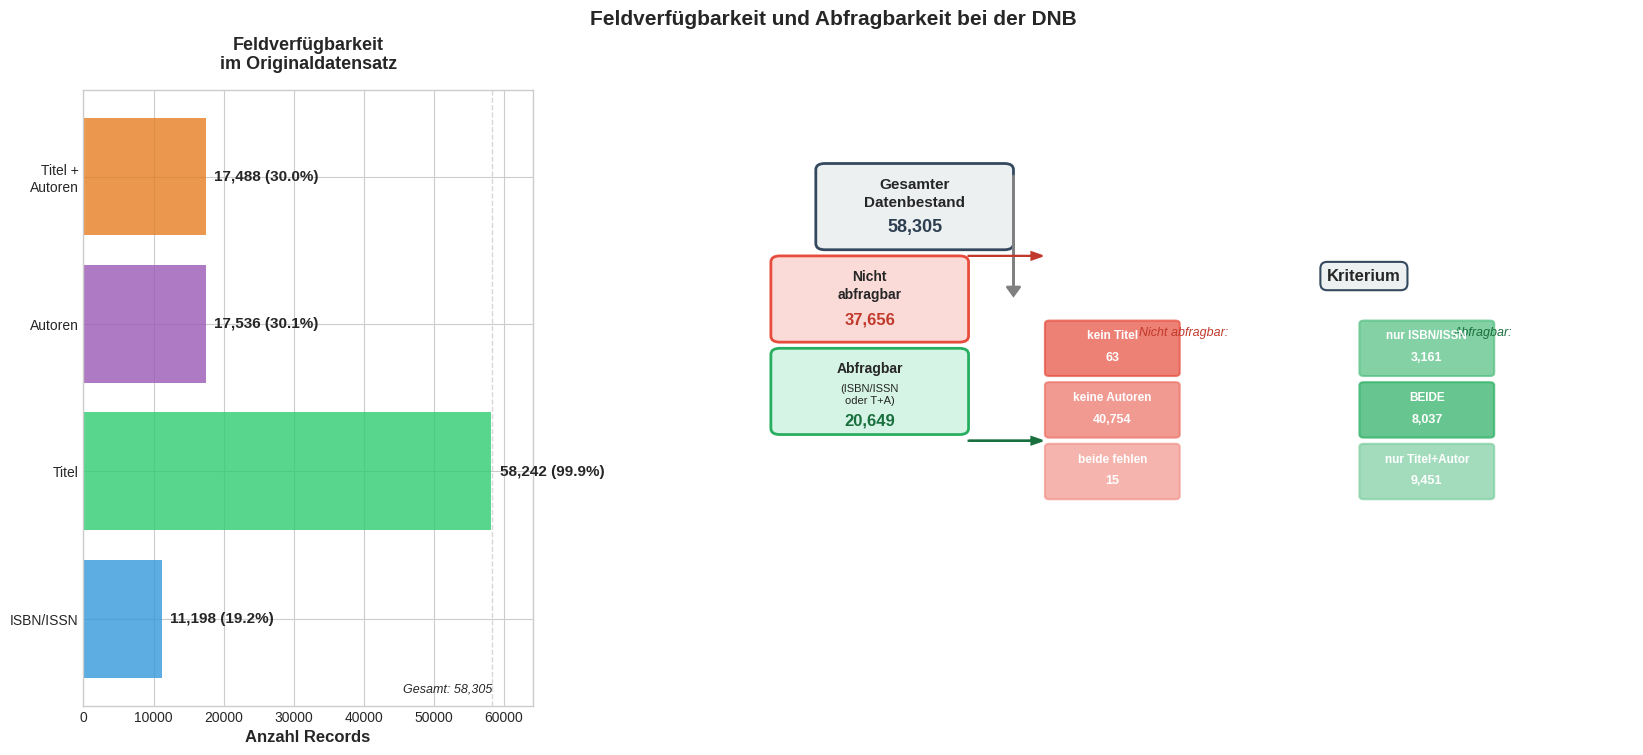

  Gespeichert: missing_fields_analysis.png


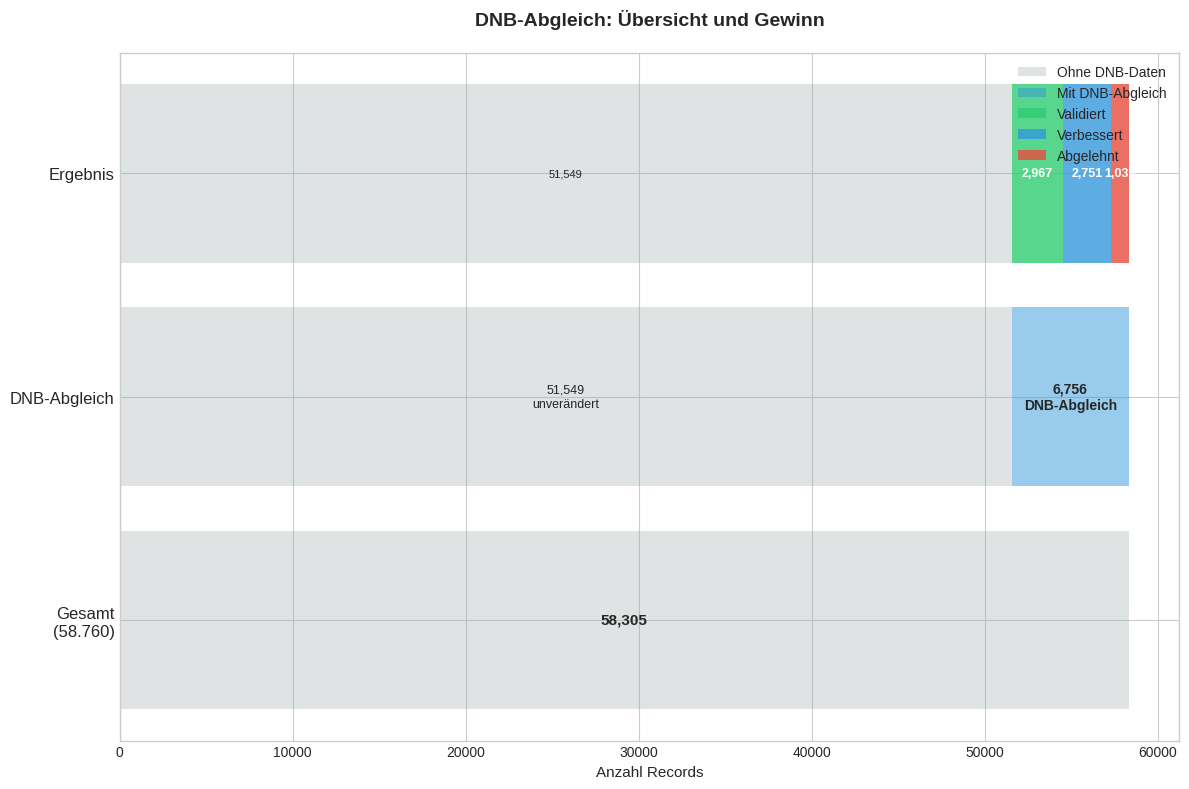

  Gespeichert: dnb_overview.png


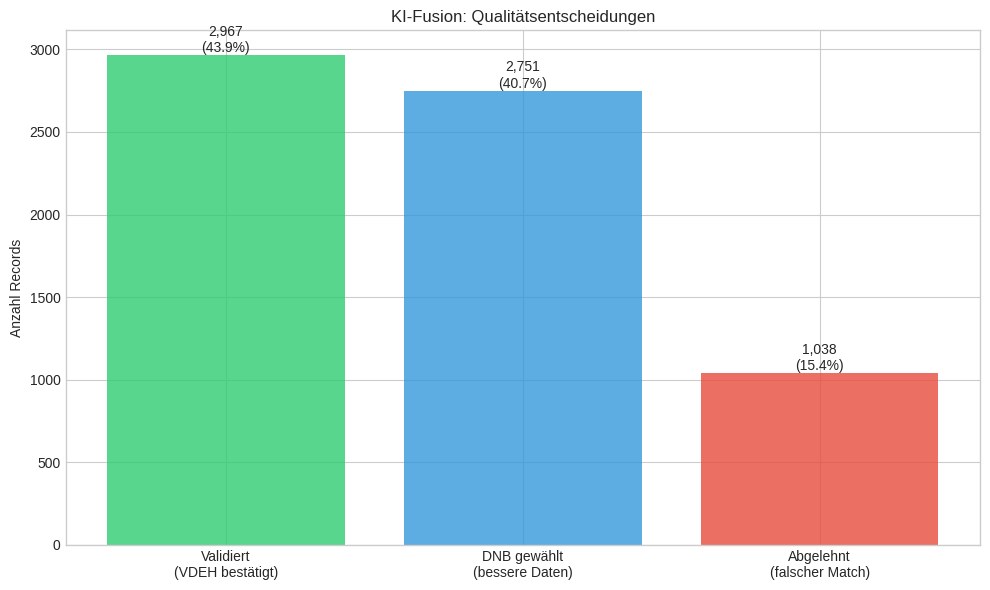

  Gespeichert: quality_decisions.png


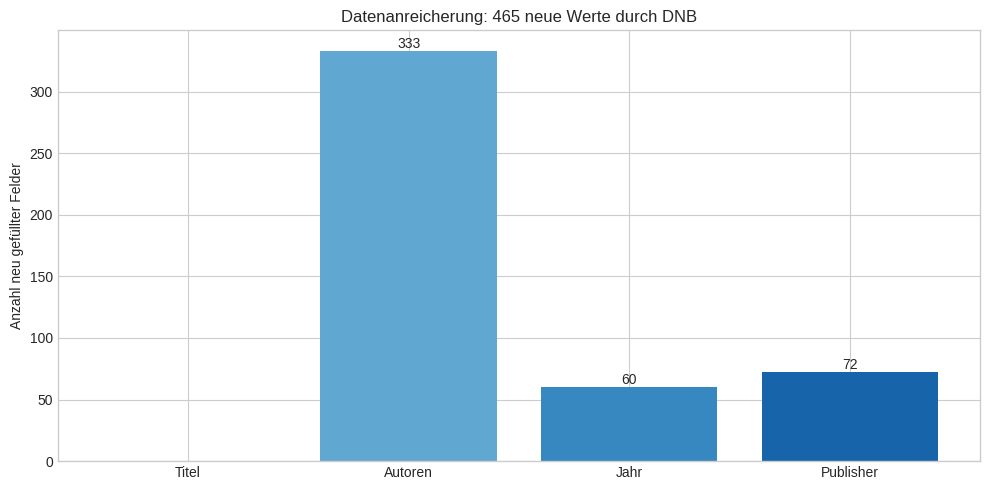

  Gespeichert: new_values.png


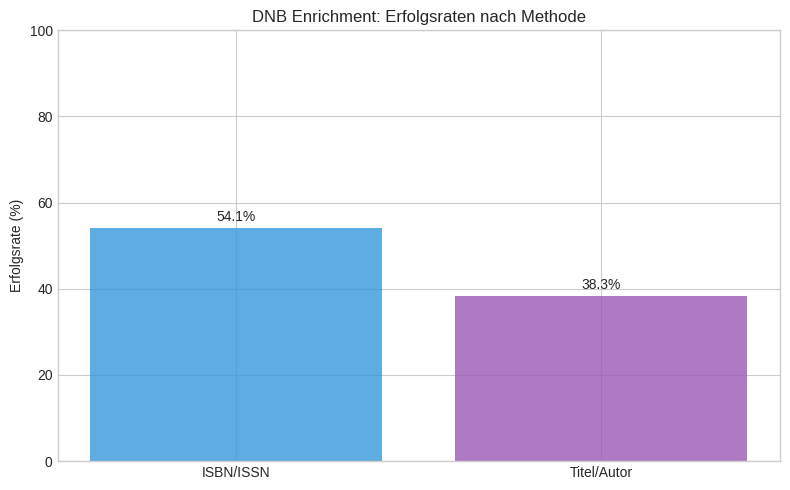

  Gespeichert: dnb_success_rates.png


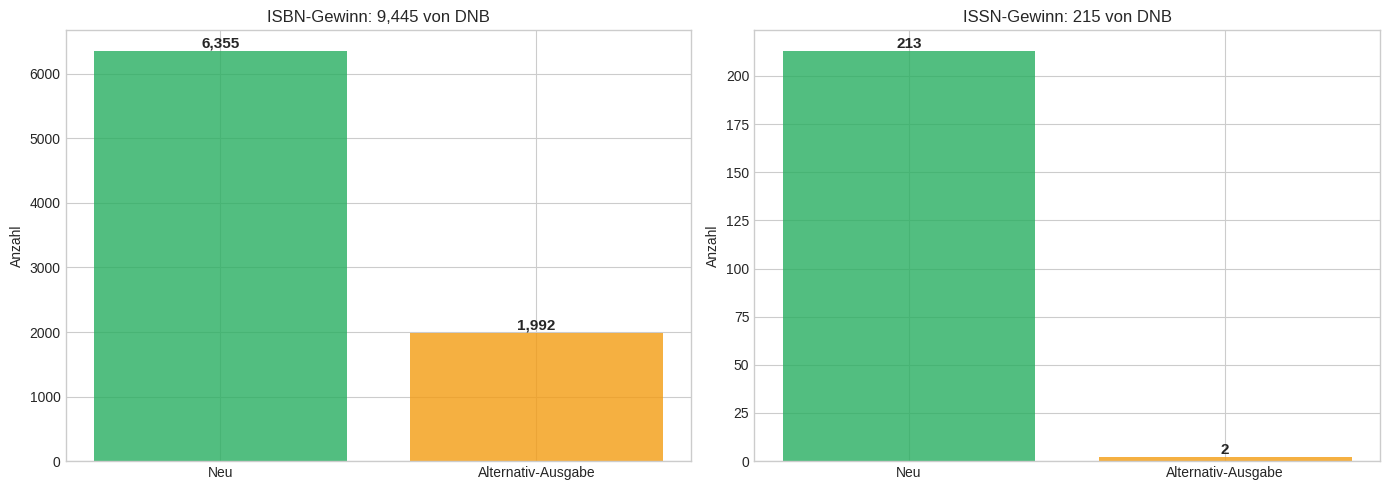

  Gespeichert: identifier_gain.png


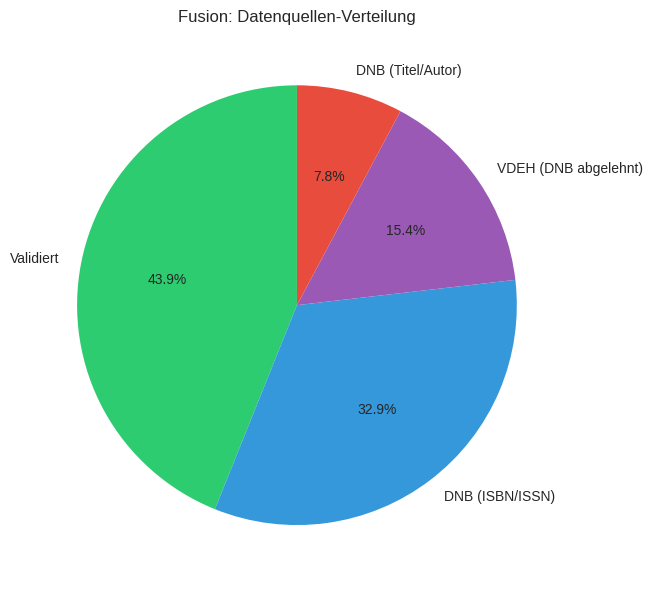

  Gespeichert: fusion_sources.png

Visualisierungen erstellt!


In [4]:
# Visualisierungen erstellen
print("Erstelle Visualisierungen...")

plt.style.use('seaborn-v0_8-whitegrid')

# 0a. Feldverfügbarkeit und Abfragbarkeit (NEU)
if df_enriched is not None:
    from matplotlib.gridspec import GridSpec
    from matplotlib.patches import FancyBboxPatch
    
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.3)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    # === LINKE SEITE: Balkendiagramm Feldverfügbarkeit ===
    total_count = len(df_enriched)
    has_identifier = df_enriched['isbn'].notna() | df_enriched['issn'].notna()
    has_title = df_enriched['title'].notna()
    has_authors = df_enriched['num_authors'] > 0
    has_title_and_authors = has_title & has_authors

    categories = ['ISBN/ISSN', 'Titel', 'Autoren', 'Titel +\nAutoren']
    values = [
        has_identifier.sum(),
        has_title.sum(),
        has_authors.sum(),
        has_title_and_authors.sum()
    ]
    percentages = [v / total_count * 100 for v in values]

    colors_bar = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']
    bars = ax1.barh(categories, values, color=colors_bar, alpha=0.8)

    ax1.set_xlabel('Anzahl Records', fontsize=12, fontweight='bold')
    ax1.set_title('Feldverfügbarkeit\nim Originaldatensatz', fontsize=13, fontweight='bold', pad=15)
    ax1.set_xlim(0, total_count * 1.1)

    for bar, val, pct in zip(bars, values, percentages):
        ax1.text(val + total_count * 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:,} ({pct:.1f}%)', va='center', fontsize=11, fontweight='bold')

    ax1.axvline(total_count, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax1.text(total_count, -0.5, f'Gesamt: {total_count:,}', ha='right', fontsize=9, style='italic')

    # === RECHTE SEITE: 3-Stufen Flow ===
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.axis('off')

    # Abfragbar: ISBN/ISSN ODER (Titel UND Autoren)
    can_query = has_identifier | has_title_and_authors
    can_query_count = can_query.sum()
    cannot_query_count = total_count - can_query_count

    # Aufschlüsselung Abfragbar
    only_isbn = has_identifier & ~has_title_and_authors
    both_methods = has_identifier & has_title_and_authors
    only_title_author = ~has_identifier & has_title_and_authors

    # Aufschlüsselung Nicht Abfragbar
    no_title = ~has_title
    no_authors = has_title & ~has_authors
    missing_both = ~has_title & ~has_authors

    # Stufe 1: Gesamt
    y_pos = 7.5
    box1 = FancyBboxPatch((1, y_pos), 2, 1.2, boxstyle="round,pad=0.1",
                          edgecolor='#34495e', facecolor='#ecf0f1', linewidth=2)
    ax2.add_patch(box1)
    ax2.text(2, y_pos + 0.9, 'Gesamter', ha='center', fontsize=11, fontweight='bold')
    ax2.text(2, y_pos + 0.6, 'Datenbestand', ha='center', fontsize=11, fontweight='bold')
    ax2.text(2, y_pos + 0.2, f'{total_count:,}', ha='center', fontsize=13, fontweight='bold', color='#2c3e50')

    # Stufe 2: Abfragbar / Nicht Abfragbar
    y_pos = 4.5

    # Nicht abfragbar (oben)
    box2a = FancyBboxPatch((0.5, y_pos + 1.5), 2, 1.2, boxstyle="round,pad=0.1",
                           edgecolor='#e74c3c', facecolor='#fadbd8', linewidth=2)
    ax2.add_patch(box2a)
    ax2.text(1.5, y_pos + 2.4, 'Nicht', ha='center', fontsize=10, fontweight='bold')
    ax2.text(1.5, y_pos + 2.1, 'abfragbar', ha='center', fontsize=10, fontweight='bold')
    ax2.text(1.5, y_pos + 1.7, f'{cannot_query_count:,}', ha='center', fontsize=12, fontweight='bold', color='#c0392b')

    # Abfragbar (unten)
    box2b = FancyBboxPatch((0.5, y_pos), 2, 1.2, boxstyle="round,pad=0.1",
                           edgecolor='#27ae60', facecolor='#d5f4e6', linewidth=2)
    ax2.add_patch(box2b)
    ax2.text(1.5, y_pos + 0.9, 'Abfragbar', ha='center', fontsize=10, fontweight='bold')
    ax2.text(1.5, y_pos + 0.6, '(ISBN/ISSN', ha='center', fontsize=8)
    ax2.text(1.5, y_pos + 0.4, 'oder T+A)', ha='center', fontsize=8)
    ax2.text(1.5, y_pos + 0.05, f'{can_query_count:,}', ha='center', fontsize=12, fontweight='bold', color='#196f3d')

    # Pfeile von Stufe 1 zu Stufe 2
    ax2.arrow(3.1, y_pos + 1.1 + 3, 0, -1.8, head_width=0.15, head_length=0.15, fc='gray', ec='gray', linewidth=1.5)

    # Stufe 3: Kriterium (Aufschlüsselung)
    y_pos_3 = 1.2
    x_start = 3.5
    box_width = 1.4
    box_height = 0.8

    # Header
    ax2.text(x_start + 3.5, y_pos_3 + 5.7, 'Kriterium', ha='center', fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.4', facecolor='#ecf0f1', edgecolor='#34495e', linewidth=1.5))

    # Nicht abfragbar - Gruppe
    ax2.text(x_start + 1, y_pos_3 + 4.8, 'Nicht abfragbar:', ha='left', fontsize=9, style='italic', color='#c0392b')

    details_not_query = [
        ('kein Titel', no_title.sum(), '#e74c3c'),
        ('keine Autoren', no_authors.sum(), '#ec7063'),
        ('beide fehlen', missing_both.sum(), '#f1948a')
    ]

    current_y = y_pos_3 + 4.2
    for label, count, color in details_not_query:
        box = FancyBboxPatch((x_start, current_y), box_width, box_height,
                            boxstyle="round,pad=0.05", edgecolor=color, facecolor=color, linewidth=1.5, alpha=0.7)
        ax2.add_patch(box)
        ax2.text(x_start + box_width/2, current_y + 0.55, label, ha='center', fontsize=8.5, fontweight='bold', color='white')
        ax2.text(x_start + box_width/2, current_y + 0.2, f'{count:,}', ha='center', fontsize=9, fontweight='bold', color='white')
        current_y -= 1.0

    # Abfragbar - Gruppe
    ax2.text(x_start + 4.5, y_pos_3 + 4.8, 'Abfragbar:', ha='left', fontsize=9, style='italic', color='#196f3d')

    details_query = [
        ('nur ISBN/ISSN', only_isbn.sum(), '#52be80'),
        ('BEIDE', both_methods.sum(), '#27ae60'),
        ('nur Titel+Autor', only_title_author.sum(), '#7dcea0')
    ]

    current_y = y_pos_3 + 4.2
    x_right = x_start + 3.5
    for label, count, color in details_query:
        box = FancyBboxPatch((x_right, current_y), box_width, box_height,
                            boxstyle="round,pad=0.05", edgecolor=color, facecolor=color, linewidth=1.5, alpha=0.7)
        ax2.add_patch(box)
        ax2.text(x_right + box_width/2, current_y + 0.55, label, ha='center', fontsize=8.5, fontweight='bold', color='white')
        ax2.text(x_right + box_width/2, current_y + 0.2, f'{count:,}', ha='center', fontsize=9, fontweight='bold', color='white')
        current_y -= 1.0

    # Pfeile von Stufe 2 zu Stufe 3
    ax2.arrow(2.6, y_pos_3 + 4.6 + 1.5, 0.7, 0, head_width=0.12, head_length=0.12, fc='#c0392b', ec='#c0392b', linewidth=1.5)
    ax2.arrow(2.6, y_pos_3 + 4.6 - 1.5, 0.7, 0, head_width=0.12, head_length=0.12, fc='#196f3d', ec='#196f3d', linewidth=1.5)

    plt.suptitle('Feldverfügbarkeit und Abfragbarkeit bei der DNB', fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(figures_dir / 'missing_fields_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  Gespeichert: missing_fields_analysis.png")

# 0b. DNB Enrichment Flow (vorhandenes Diagramm kopieren)
import shutil
source_flow = processed_dir / 'dnb_enrichment_flow.png'
target_flow = figures_dir / 'dnb_enrichment_flow.png'
if source_flow.exists():
    shutil.copy(source_flow, target_flow)
    print(f"  Kopiert: dnb_enrichment_flow.png")

# 0c. Übersicht: DNB-Gewinn als Mengendiagramm
if 'quality' in stats and 'improvements' in stats:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Bereiche definieren
    total_records = stats['total_records']
    fusion_count = stats['fusion_count']
    no_dnb = total_records - fusion_count
    validated = stats['quality']['validated']
    dnb_preferred = stats['quality']['dnb_preferred']
    rejected = stats['quality']['rejected_matches']
    
    # Sankey-ähnliche Darstellung mit gestapelten Balken
    categories = ['Gesamt\n(58.760)', 'DNB-Abgleich', 'Ergebnis']
    
    # Farben
    color_no_dnb = '#95a5a6'
    color_validated = '#2ecc71'
    color_improved = '#3498db'
    color_rejected = '#e74c3c'
    
    # Erste Säule: Gesamt
    ax.barh(0, total_records, height=0.8, color=color_no_dnb, alpha=0.3, label='Ohne DNB-Daten')
    
    # Zweite Säule: Mit DNB-Abgleich
    ax.barh(1, no_dnb, height=0.8, left=0, color=color_no_dnb, alpha=0.3)
    ax.barh(1, fusion_count, height=0.8, left=no_dnb, color='#3498db', alpha=0.5, label='Mit DNB-Abgleich')
    
    # Dritte Säule: Aufgeschlüsselt
    ax.barh(2, no_dnb, height=0.8, left=0, color=color_no_dnb, alpha=0.3)
    current_pos = no_dnb
    ax.barh(2, validated, height=0.8, left=current_pos, color=color_validated, alpha=0.8, label='Validiert')
    current_pos += validated
    ax.barh(2, dnb_preferred, height=0.8, left=current_pos, color=color_improved, alpha=0.8, label='Verbessert')
    current_pos += dnb_preferred
    ax.barh(2, rejected, height=0.8, left=current_pos, color=color_rejected, alpha=0.8, label='Abgelehnt')
    
    # Beschriftungen
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(categories, fontsize=12)
    ax.set_xlabel('Anzahl Records', fontsize=11)
    ax.set_title('DNB-Abgleich: Übersicht und Gewinn', fontsize=14, fontweight='bold', pad=20)
    
    # Werte einzeichnen
    ax.text(total_records/2, 0, f'{total_records:,}', ha='center', va='center', fontsize=11, fontweight='bold')
    
    ax.text(no_dnb/2, 1, f'{no_dnb:,}\nunverändert', ha='center', va='center', fontsize=9)
    ax.text(no_dnb + fusion_count/2, 1, f'{fusion_count:,}\nDNB-Abgleich', ha='center', va='center', fontsize=10, fontweight='bold')
    
    ax.text(no_dnb/2, 2, f'{no_dnb:,}', ha='center', va='center', fontsize=8)
    ax.text(no_dnb + validated/2, 2, f'{validated:,}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax.text(no_dnb + validated + dnb_preferred/2, 2, f'{dnb_preferred:,}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    ax.text(no_dnb + validated + dnb_preferred + rejected/2, 2, f'{rejected:,}', ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    
    ax.legend(loc='upper right', fontsize=10)
    ax.set_xlim(0, total_records * 1.05)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'dnb_overview.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  Gespeichert: dnb_overview.png")

# 1. KI-Fusion Qualitätsentscheidungen
if 'quality' in stats:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['Validiert\n(VDEH bestätigt)', 'DNB gewählt\n(bessere Daten)', 'Abgelehnt\n(falscher Match)']
    values = [
        stats['quality']['validated'],
        stats['quality']['dnb_preferred'],
        stats['quality']['rejected_matches']
    ]
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.8)
    
    ax.set_ylabel('Anzahl Records')
    ax.set_title('KI-Fusion: Qualitätsentscheidungen')
    
    # Werte und Prozent über Balken
    total = sum(values)
    for bar, val in zip(bars, values):
        pct = val / total * 100 if total > 0 else 0
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'quality_decisions.png', dpi=150)
    plt.show()
    print(f"  Gespeichert: quality_decisions.png")

# 2. Neu gefüllte Felder durch DNB
if 'improvements' in stats:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    fields = ['Titel', 'Autoren', 'Jahr', 'Publisher']
    values = [
        stats['improvements'].get('title', 0),
        stats['improvements'].get('authors_str', 0),
        stats['improvements'].get('year', 0),
        stats['improvements'].get('publisher', 0)
    ]
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(fields)))
    bars = ax.bar(fields, values, color=colors)
    
    ax.set_ylabel('Anzahl neu gefüllter Felder')
    ax.set_title(f'Datenanreicherung: {stats["improvements"]["total_new_values"]:,} neue Werte durch DNB')
    
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:,}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'new_values.png', dpi=150)
    plt.show()
    print(f"  Gespeichert: new_values.png")

# 3. DNB Enrichment Erfolgsraten
if 'dnb_isbn_issn' in stats and 'dnb_title_author' in stats:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    methods = ['ISBN/ISSN', 'Titel/Autor']
    success = [
        stats['dnb_isbn_issn']['success_rate'],
        stats['dnb_title_author']['success_rate']
    ]
    
    colors = ['#3498db', '#9b59b6']
    bars = ax.bar(methods, success, color=colors, alpha=0.8)
    
    ax.set_ylabel('Erfolgsrate (%)')
    ax.set_title('DNB Enrichment: Erfolgsraten nach Methode')
    ax.set_ylim(0, 100)
    
    for bar, rate in zip(bars, success):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'dnb_success_rates.png', dpi=150)
    plt.show()
    print(f"  Gespeichert: dnb_success_rates.png")

# 4. Identifier-Gewinn (detailliert)
if 'isbn_detailed' in stats and 'issn_detailed' in stats:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # ISBN
    isbn_categories = ['Neu', 'Alternativ-Ausgabe']
    isbn_values = [stats['isbn_detailed']['new'], stats['isbn_detailed']['alternative']]
    colors_isbn = ['#27ae60', '#f39c12']
    
    bars1 = ax1.bar(isbn_categories, isbn_values, color=colors_isbn, alpha=0.8)
    ax1.set_ylabel('Anzahl')
    ax1.set_title(f"ISBN-Gewinn: {stats['isbn_detailed']['total_from_dnb']:,} von DNB")
    
    for bar, val in zip(bars1, isbn_values):
        if val > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # ISSN
    issn_categories = ['Neu', 'Alternativ-Ausgabe']
    issn_values = [stats['issn_detailed']['new'], stats['issn_detailed']['alternative']]
    colors_issn = ['#27ae60', '#f39c12']
    
    bars2 = ax2.bar(issn_categories, issn_values, color=colors_issn, alpha=0.8)
    ax2.set_ylabel('Anzahl')
    ax2.set_title(f"ISSN-Gewinn: {stats['issn_detailed']['total_from_dnb']:,} von DNB")
    
    for bar, val in zip(bars2, issn_values):
        if val > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'identifier_gain.png', dpi=150)
    plt.show()
    print(f"  Gespeichert: identifier_gain.png")

# 5. Fusion-Quellen Verteilung (Pie Chart)
if 'fusion_sources' in stats:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sources = stats['fusion_sources']
    sources = {k: v for k, v in sources.items() if k is not None}
    
    if sources:
        # Bessere Labels
        label_map = {
            'confirmed': 'Validiert',
            'dnb_id': 'DNB (ISBN/ISSN)',
            'dnb_title_author': 'DNB (Titel/Autor)',
            'vdeh': 'VDEH (DNB abgelehnt)'
        }
        labels = [label_map.get(k, k) for k in sources.keys()]
        values = list(sources.values())
        colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
        
        ax.pie(values, labels=labels, autopct='%1.1f%%', colors=colors[:len(labels)], startangle=90)
        ax.set_title('Fusion: Datenquellen-Verteilung')
        
        plt.tight_layout()
        plt.savefig(figures_dir / 'fusion_sources.png', dpi=150)
        plt.show()
        print(f"  Gespeichert: fusion_sources.png")

print("\nVisualisierungen erstellt!")

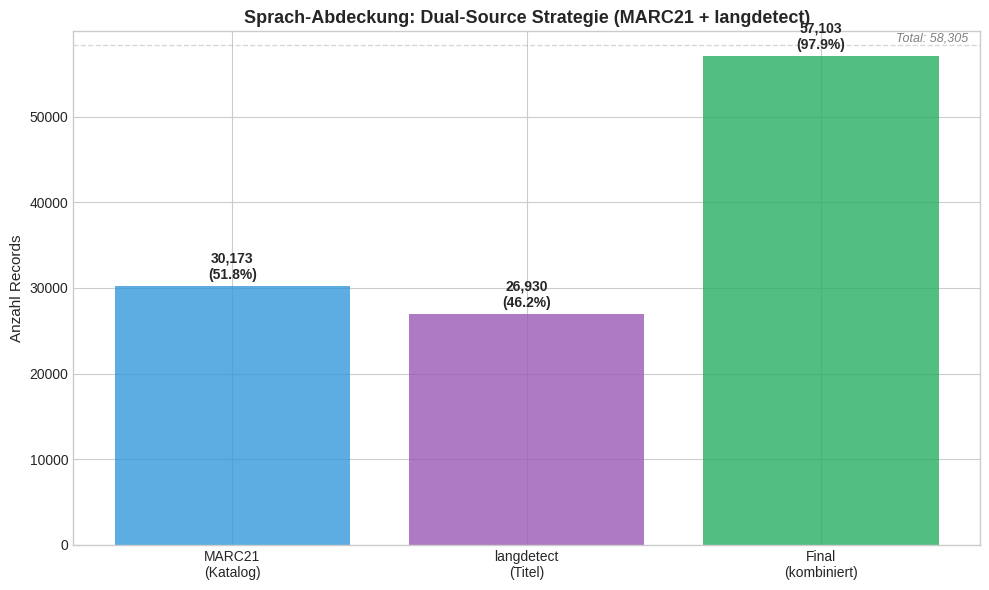

  Gespeichert: language_coverage.png

Visualisierungen erstellt!


In [5]:
# 6. Language Coverage (Dual-Source Strategy) - NEU
if 'language' in stats:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['MARC21\n(Katalog)', 'langdetect\n(Titel)', 'Final\n(kombiniert)']
    values = [
        stats['language']['marc21_count'],
        stats['language']['langdetect_count'],
        stats['language']['total_with_lang']
    ]
    percentages = [v / stats['total_records'] * 100 for v in values]
    
    colors = ['#3498db', '#9b59b6', '#27ae60']
    bars = ax.bar(categories, values, color=colors, alpha=0.8)
    
    ax.set_ylabel('Anzahl Records', fontsize=11)
    ax.set_title('Sprach-Abdeckung: Dual-Source Strategie (MARC21 + langdetect)', fontsize=13, fontweight='bold')
    
    for bar, val, pct in zip(bars, values, percentages):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 500,
                f'{val:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Horizontale Linie für Gesamt-Records
    ax.axhline(stats['total_records'], color='gray', linestyle='--', alpha=0.3, linewidth=1)
    ax.text(2.5, stats['total_records'] + 500, f'Total: {stats["total_records"]:,}', 
            ha='right', fontsize=9, style='italic', color='gray')
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'language_coverage.png', dpi=150)
    plt.show()
    print(f"  Gespeichert: language_coverage.png")

print("\nVisualisierungen erstellt!")

In [6]:
# Report generieren (GAP-FOKUSSIERT)
print("Generiere gap-fokussierten Report...")

report_date = datetime.now().strftime('%d.%m.%Y')
total = stats.get('total_records', 0)
data_source = stats.get('data_source', {})
language_stats = stats.get('language', {})
original_gaps = stats.get('original_gaps', {})
gaps_filled = stats.get('gaps_filled', {})
quality = stats.get('quality', {})
improvements = stats.get('improvements', {})

# Calculate gap closure rates
isbn_gap_closure = (gaps_filled.get('isbn', 0) / original_gaps.get('isbn_missing', 1) * 100) if original_gaps.get('isbn_missing', 0) > 0 else 0
language_gap_closure = (language_stats.get('gap_filled', 0) / original_gaps.get('language_missing', 1) * 100) if original_gaps.get('language_missing', 0) > 0 else 0

report = f"""# VDEH Bibliothek Datenanreicherung - Projektbericht

**Fokus:** Lücken-Analyse und Pipeline-Mehrwert

**Erstellt:** {report_date}  
**Projekt:** {config.get('project.name')}  
**Version:** {config.get('project.version')}

---

## 1. Executive Summary: Was die Pipeline leistet

### Problem: Lücken im MARC21-Datensatz

Der MARC21-Datensatz ({data_source.get('file', 'N/A')}) enthält {total:,} Records, aber es fehlen kritische Metadaten:

| Feld | Fehlend in MARC21 | Prozent |
|------|-------------------|---------|
| Titel | {original_gaps.get('title_missing', 0):,} | {original_gaps.get('title_missing', 0)/total*100:.1f}% |
| **ISBN** | **{original_gaps.get('isbn_missing', 0):,}** | **{original_gaps.get('isbn_missing', 0)/total*100:.1f}%** |
| **ISSN** | {original_gaps.get('issn_missing', 0):,} | {original_gaps.get('issn_missing', 0)/total*100:.1f}% |
| **Sprache** | {original_gaps.get('language_missing', 0):,} | {original_gaps.get('language_missing', 0)/total*100:.1f}% |
| Autoren | {original_gaps.get('authors_missing', 0):,} | {original_gaps.get('authors_missing', 0)/total*100:.1f}% |
| Jahr | {original_gaps.get('year_missing', 0):,} | {original_gaps.get('year_missing', 0)/total*100:.1f}% |
| Publisher | {original_gaps.get('publisher_missing', 0):,} | {original_gaps.get('publisher_missing', 0)/total*100:.1f}% |

### Lösung: Pipeline-Anreicherung

Die Pipeline füllt diese Lücken durch DNB-Abgleich und KI-Fusion:

| Feld | Neu gefüllt | Korrigiert | Bestätigt | Gesamt bearbeitet |
|------|------------|------------|-----------|-------------------|
| **ISBN** | **+{stats.get('corrections_confirmations', {}).get('isbn', {}).get('filled', gaps_filled.get('isbn', 0)):,}** | {stats.get('corrections_confirmations', {}).get('isbn', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('isbn', {}).get('confirmed', 0):,} | **{stats.get('corrections_confirmations', {}).get('isbn', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('isbn', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('isbn', {}).get('confirmed', 0):,}** |
| **ISSN** | **+{stats.get('corrections_confirmations', {}).get('issn', {}).get('filled', gaps_filled.get('issn', 0)):,}** | {stats.get('corrections_confirmations', {}).get('issn', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('issn', {}).get('confirmed', 0):,} | **{stats.get('corrections_confirmations', {}).get('issn', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('issn', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('issn', {}).get('confirmed', 0):,}** |
| **Sprache** | **+{stats.get('corrections_confirmations', {}).get('language', {}).get('filled', language_stats.get('gap_filled', 0)):,}** | {stats.get('corrections_confirmations', {}).get('language', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('language', {}).get('confirmed', 0):,} | **{stats.get('corrections_confirmations', {}).get('language', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('language', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('language', {}).get('confirmed', 0):,}** |
| Autoren | +{stats.get('corrections_confirmations', {}).get('authors', {}).get('filled', gaps_filled.get('authors', 0)):,} | {stats.get('corrections_confirmations', {}).get('authors', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('authors', {}).get('confirmed', 0):,} | {stats.get('corrections_confirmations', {}).get('authors', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('authors', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('authors', {}).get('confirmed', 0):,} |
| Jahr | +{stats.get('corrections_confirmations', {}).get('year', {}).get('filled', gaps_filled.get('year', 0)):,} | {stats.get('corrections_confirmations', {}).get('year', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('year', {}).get('confirmed', 0):,} | {stats.get('corrections_confirmations', {}).get('year', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('year', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('year', {}).get('confirmed', 0):,} |
| Publisher | +{stats.get('corrections_confirmations', {}).get('publisher', {}).get('filled', gaps_filled.get('publisher', 0)):,} | {stats.get('corrections_confirmations', {}).get('publisher', {}).get('corrected', 0):,} | {stats.get('corrections_confirmations', {}).get('publisher', {}).get('confirmed', 0):,} | {stats.get('corrections_confirmations', {}).get('publisher', {}).get('filled', 0) + stats.get('corrections_confirmations', {}).get('publisher', {}).get('corrected', 0) + stats.get('corrections_confirmations', {}).get('publisher', {}).get('confirmed', 0):,} |

**Erklärung der Spalten:**
- **Neu gefüllt**: MARC21 hatte keinen Wert → Pipeline füllte ihn
- **Korrigiert**: MARC21 hatte einen Wert → Pipeline ersetzte ihn mit DNB-Daten (weil DNB besser war)
- **Bestätigt**: MARC21 hatte einen Wert → Pipeline bestätigte ihn (gleich oder DNB-Match abgelehnt)
- **Gesamt bearbeitet**: Summe aller Pipeline-Aktivitäten für dieses Feld

### Hauptmehrwert

1. **{gaps_filled.get('isbn', 0):,} neue ISBNs** ({isbn_gap_closure:.1f}% der fehlenden ISBNs) - essentiell für Katalogisierung
2. **{language_stats.get('gap_filled', 0):,} Sprachinformationen** ({language_gap_closure:.1f}% der fehlenden) - von {original_gaps.get('language_missing', 0)/total*100:.1f}% auf {language_stats.get('coverage_pct', 0):.1f}% Abdeckung
3. **{quality.get('rejected_matches', 0):,} falsche DNB-Matches erkannt** - verhindert Datenverschlechterung
4. **{quality.get('dnb_preferred', 0):,} Records verbessert** - höhere Datenqualität

---

## 2. Detaillierte Gap-Analyse

### 2.1 ISBN-Lücke: {original_gaps.get('isbn_missing', 0):,} fehlende ISBNs

**Ausgangslage:**
- MARC21 enthält nur {total - original_gaps.get('isbn_missing', 0):,} ISBNs ({(total - original_gaps.get('isbn_missing', 0))/total*100:.1f}%)
- **{original_gaps.get('isbn_missing', 0):,} Records ohne ISBN** ({original_gaps.get('isbn_missing', 0)/total*100:.1f}%)

**Pipeline-Lösung:**
- DNB-Abfrage über ISBN/ISSN: {stats.get('isbn_gain', 0):,} neue ISBNs
- DNB-Abfrage über Titel/Autor: {stats.get('isbn_gain_ta', 0):,} neue ISBNs
- **Gesamt: +{gaps_filled.get('isbn', 0):,} ISBNs** ({isbn_gap_closure:.1f}% der Lücke geschlossen)

**Detaillierung:**
- Komplett neue ISBNs: {stats.get('isbn_detailed', {}).get('new', 0):,}
- Alternative Ausgaben: {stats.get('isbn_detailed', {}).get('alternative', 0):,}

**Verbleibende Lücke:** {original_gaps.get('isbn_missing', 0) - gaps_filled.get('isbn', 0):,} Records

![Identifier-Gewinn](figures/identifier_gain.png)

### 2.2 Sprach-Lücke: {original_gaps.get('language_missing', 0):,} fehlende Sprachinformationen

**Ausgangslage:**
- MARC21 enthält nur {total - original_gaps.get('language_missing', 0):,} Sprachcodes ({(total - original_gaps.get('language_missing', 0))/total*100:.1f}%)
- **{original_gaps.get('language_missing', 0):,} Records ohne Sprache** ({original_gaps.get('language_missing', 0)/total*100:.1f}%)

**Pipeline-Lösung (Dual-Source):**
1. MARC21-Katalogdaten: {language_stats.get('marc21_count', 0):,} Records (100% genau)
2. langdetect (Titel-Analyse): {language_stats.get('langdetect_count', 0):,} zusätzliche Records
3. **Kombiniert: {language_stats.get('total_with_lang', 0):,} Records** ({language_stats.get('coverage_pct', 0):.1f}% Abdeckung)

**Lücken-Schließung:** +{language_stats.get('gap_filled', 0):,} Records ({language_gap_closure:.1f}%)

**Verbleibende Lücke:** {total - language_stats.get('total_with_lang', 0):,} Records ({(total - language_stats.get('total_with_lang', 0))/total*100:.1f}%)

![Language Coverage](figures/language_coverage.png)

### 2.3 Weitere Lücken

| Feld | MARC21-Lücke | Gefüllt | Verbleibend |
|------|------------|---------|-------------|
| ISSN | {original_gaps.get('issn_missing', 0):,} | +{gaps_filled.get('issn', 0):,} | {original_gaps.get('issn_missing', 0) - gaps_filled.get('issn', 0):,} |
| Autoren | {original_gaps.get('authors_missing', 0):,} | +{gaps_filled.get('authors', 0):,} | {original_gaps.get('authors_missing', 0) - gaps_filled.get('authors', 0):,} |
| Jahr | {original_gaps.get('year_missing', 0):,} | +{gaps_filled.get('year', 0):,} | {original_gaps.get('year_missing', 0) - gaps_filled.get('year', 0):,} |
| Publisher | {original_gaps.get('publisher_missing', 0):,} | +{gaps_filled.get('publisher', 0):,} | {original_gaps.get('publisher_missing', 0) - gaps_filled.get('publisher', 0):,} |

---

## 3. Qualitätssicherung: Warum KI-Fusion kritisch ist

### Das Problem: Falsche DNB-Matches

Von {stats.get('fusion_count', 0):,} DNB-Matches waren **{quality.get('rejected_matches', 0):,} falsch** ({quality.get('rejected_matches', 0)/stats.get('fusion_count', 1)*100:.1f}%).

**Ohne KI-Fusion würden Sie {quality.get('rejected_matches', 0):,} fehlerhafte Daten übernehmen!**

### KI-Fusion Entscheidungen

| Entscheidung | Anzahl | Anteil | Bedeutung |
|--------------|--------|--------|-----------|
| **Validiert** | {quality.get('validated', 0):,} | {quality.get('validated', 0) / stats.get('fusion_count', 1) * 100:.1f}% | MARC21 war korrekt |
| **DNB gewählt** | {quality.get('dnb_preferred', 0):,} | {quality.get('dnb_preferred', 0) / stats.get('fusion_count', 1) * 100:.1f}% | DNB lieferte bessere Daten |
| **Abgelehnt** | {quality.get('rejected_matches', 0):,} | {quality.get('rejected_matches', 0) / stats.get('fusion_count', 1) * 100:.1f}% | Falscher Match verhindert |

![Qualitätsentscheidungen](figures/quality_decisions.png)

---

## 4. ROI-Analyse: Lohnt sich die Pipeline?

### Aufwand
- Setup: **Bereits erledigt**
- Ausführung: ~10-12 Stunden (einmalig)
- Wartung: Minimal (bei Datenaktualisierung)

### Nutzen

| Kriterium | Wert | Kommentar |
|-----------|------|-----------|
| **ISBN-Gewinn** | +{gaps_filled.get('isbn', 0):,} | Unverzichtbar für Katalogisierung |
| **Sprach-Abdeckung** | {language_stats.get('coverage_pct', 0):.1f}% | Von {(total - original_gaps.get('language_missing', 0))/total*100:.1f}% auf {language_stats.get('coverage_pct', 0):.1f}% |
| **Fehler verhindert** | {quality.get('rejected_matches', 0):,} | Datenverschlechterung vermieden |
| **Records verbessert** | {quality.get('dnb_preferred', 0):,} | Höhere Qualität |

### Empfehlung

**Die Pipeline lohnt sich**, weil:
1. **{isbn_gap_closure:.1f}% der ISBN-Lücke** wird geschlossen
2. **{language_gap_closure:.1f}% der Sprach-Lücke** wird geschlossen
3. **{quality.get('rejected_matches', 0):,} Fehler** werden verhindert
4. Setup ist fertig, nur Ausführung nötig

---

## 5. Technische Details

### 5.1 Pipeline-Ablauf

```
marcVDEH.xml (MARC21, {total:,} Records)
    |
    v
[01] MARC21 Parsing & Language Extraction
    |
    v
[02] Preprocessing & Validation
    |
    v
[03] Language Detection (Dual-Source)
    |
    v
[04] DNB Enrichment (ISBN/ISSN + Titel/Autor)
    |
    v
[05] KI-Fusion (Ollama LLM) + Lücken-Füllung
    |
    v
Finaler Datensatz (Lücken geschlossen)
```

### 5.2 DNB Enrichment Erfolgsraten

| Methode | Erfolgsrate |
|---------|-------------|
| ISBN/ISSN-Suche | {stats.get('dnb_isbn_issn', {}).get('success_rate', 0):.1f}% |
| Titel/Autor-Suche | {stats.get('dnb_title_author', {}).get('success_rate', 0):.1f}% |

![DNB Erfolgsraten](figures/dnb_success_rates.png)

### 5.3 Konfiguration

- **Datenquelle:** {data_source.get('file', 'N/A')} ({data_source.get('format', 'N/A')})
- **DNB API Rate Limit:** 1.0s zwischen Anfragen
- **Fusion Model:** Ollama llama3.3:70b (lokal, kostenlos)
- **Fusion Timeout:** 220s

### 5.4 Finale Datenqualität

| Feld | Vollständigkeit | Verbesserung |
|------|----------------|--------------|
| Titel | {stats['completeness']['title']}{total:,} ({stats['completeness']['title']/total*100:.1f}%) | - |
| **ISBN** | {stats['completeness']['isbn']:,} ({stats['completeness']['isbn']/total*100:.1f}%) | **+{gaps_filled.get('isbn', 0):,}** |
| **ISSN** | {stats['completeness']['issn']:,} ({stats['completeness']['issn']/total*100:.1f}%) | **+{gaps_filled.get('issn', 0):,}** |
| **Sprache** | {language_stats.get('total_with_lang', 0):,} ({language_stats.get('coverage_pct', 0):.1f}%) | **+{language_stats.get('gap_filled', 0):,}** |
| Autoren | {stats['completeness']['authors']:,} ({stats['completeness']['authors']/total*100:.1f}%) | +{gaps_filled.get('authors', 0):,} |
| Jahr | {stats['completeness']['year']:,} ({stats['completeness']['year']/total*100:.1f}%) | +{gaps_filled.get('year', 0):,} |
| Publisher | {stats['completeness']['publisher']:,} ({stats['completeness']['publisher']/total*100:.1f}%) | +{gaps_filled.get('publisher', 0):,} |

---

*Report generiert am {report_date} | Fokus: Gap-Analyse und Pipeline-Mehrwert*
"""

# Save report
report_path = reports_dir / 'vdeh_enrichment_report.md'
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report)

print(f"\nGap-fokussierter Report gespeichert: {report_path}")
print(f"Figures gespeichert: {figures_dir}")

Generiere gap-fokussierten Report...

Gap-fokussierter Report gespeichert: /media/sz/Data/Bibo/analysis/reports/vdeh_enrichment_report.md
Figures gespeichert: /media/sz/Data/Bibo/analysis/reports/figures


In [7]:
# Report Preview (erste 100 Zeilen)
print("=" * 80)
print("REPORT PREVIEW")
print("=" * 80)
print()

lines = report.split('\n')[:100]
print('\n'.join(lines))

if len(report.split('\n')) > 100:
    print(f"\n... ({len(report.split(chr(10))) - 100} weitere Zeilen)")

print()
print("=" * 80)
print(f"Vollständiger Report: {report_path}")

REPORT PREVIEW

# VDEH Bibliothek Datenanreicherung - Projektbericht

**Fokus:** Lücken-Analyse und Pipeline-Mehrwert

**Erstellt:** 11.12.2025  
**Projekt:** Dual-Source Bibliothek Bestandsvergleich  
**Version:** 2.0.0

---

## 1. Executive Summary: Was die Pipeline leistet

### Problem: Lücken im MARC21-Datensatz

Der MARC21-Datensatz (marcVDEH.xml) enthält 58,305 Records, aber es fehlen kritische Metadaten:

| Feld | Fehlend in MARC21 | Prozent |
|------|-------------------|---------|
| **ISBN** | **47,798** | **82.0%** |
| **ISSN** | 57,595 | 98.8% |
| **Sprache** | 28,132 | 48.2% |
| Autoren | 40,769 | 69.9% |
| Jahr | 24,992 | 42.9% |
| Publisher | 34,671 | 59.5% |

### Lösung: Pipeline-Anreicherung

Die Pipeline füllt diese Lücken durch DNB-Abgleich und KI-Fusion:

| Feld | Neu gefüllt | Schließungsrate |
|------|------------|---------------------|
| **ISBN** | **+0** | **0.0%** |
| **ISSN** | **+0** | 0.0% |
| **Sprache** | **+26,930** | **95.7%** |
| Autoren | +131 | 0.3% |
|

## Export-Optionen

Der Markdown-Report kann mit pandoc in andere Formate konvertiert werden:

```bash
# PDF (benötigt LaTeX)
pandoc reports/vdeh_enrichment_report.md -o reports/vdeh_enrichment_report.pdf

# HTML
pandoc reports/vdeh_enrichment_report.md -o reports/vdeh_enrichment_report.html --standalone

# Word
pandoc reports/vdeh_enrichment_report.md -o reports/vdeh_enrichment_report.docx
```